In [5]:
import re
import mysql.connector as connection
import xyzservices.providers as xyz
import pandas as pd
import sshtunnel
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import folium
import webbrowser as web
import seaborn as sns
from haversine import haversine, Unit
from folium import plugins
from shapely.geometry import Point

In [6]:
base_date = "2022-07-11"

In [7]:
ssh_username = "xxx"
ssh_password = "xxx"

tunnel = sshtunnel.SSHTunnelForwarder(("xxx", 22), ssh_username = ssh_username, ssh_password = ssh_password, remote_bind_address = ("localhost", 3306))
tunnel.start()
mydb = connection.connect(user = "root", password = "123123123", host = "localhost", database = "busanalysis_dw", port = tunnel.local_bind_port, use_pure = True)
vw_itinerary = pd.read_sql("SELECT line_code, itinerary_id, legacy_id, seq FROM vw_itinerary WHERE base_date = '{0}'".format(base_date), mydb)
mydb.close()

In [8]:
vw_event = pd.read_parquet("correlacoes/events.parquet")
vw_event['hour'] = vw_event["event_timestamp"].dt.hour
vw_event['base_date'] = pd.to_datetime(vw_event["base_date"])
vw_event.query(f"base_date == '{base_date}'", inplace = True)
vw_event.query("6 <= hour <= 19", inplace = True)

In [9]:
def extract_terminal_name(x):
    if isinstance(x, str):
        pattern = r'Terminal (Capão da Imbuia|Pinheirinho|Portão|Bairro Alto|Barreirinha|Boa Vista|Boqueirão|Cabral|Cachoeira|Caiuá|Campina do Siqueira|Campo Comprido|Capão Raso|Carmo|Centenário|CIC|Fazendinha|Hauer|Maracanã|Oficinas|Pinhais|Santa Cândida|Santa Felicidade|Sítio Cercado|Tatuquara)'

        match = re.search(pattern, x)
        if match:
            return match.group()
    return x

In [10]:
dim_bus_stop = pd.read_parquet("correlacoes/dim_bus_stop.parquet").drop(columns=['last_update'])
dim_bus_stop['name_normalized'] = np.where( (dim_bus_stop.type_norm == 'Bus terminal'),  dim_bus_stop.name , '')
dim_bus_stop['name_normalized'] = dim_bus_stop['name_normalized'].apply(extract_terminal_name)
terminais_dummy_ids = dim_bus_stop.query("~name_normalized.isna() and name_normalized != ''").groupby(['name_normalized']).agg(dummy_legacy_id = ('legacy_id', 'sum')).reset_index()
dim_bus_stop = dim_bus_stop.merge(terminais_dummy_ids, on=['name_normalized'], how='left')
dim_bus_stop['dummy_legacy_id'] = np.where( (dim_bus_stop.name_normalized == '') , dim_bus_stop.legacy_id, dim_bus_stop.dummy_legacy_id)
dim_bus_stop['dummy_legacy_id'] = dim_bus_stop.dummy_legacy_id.astype(int)

In [11]:
#line_code = ["020", "829", "303", "023", "203", "022", "654", "386"]
#line_code = ["302"]
#a = vw_itinerary.query(f"line_code != {line_code}").filter(['line_code', 'itinerary_id', 'legacy_id', 'seq']).copy()
#a = vw_itinerary.query(f"line_code == {line_code}").filter(['line_code', 'itinerary_id', 'legacy_id', 'seq']).copy()
a = vw_itinerary.copy()
a = pd.merge(a, vw_event.filter(['line_code', 'itinerary_id']).drop_duplicates(), on = ['line_code', 'itinerary_id'], how = 'inner')

In [12]:
a = pd.merge(a, dim_bus_stop.filter(['legacy_id', 'dummy_legacy_id']), left_on = 'legacy_id', right_on = 'legacy_id', how = 'left').drop(columns = ['legacy_id'])

In [13]:
bs = dim_bus_stop.copy()
bs['name_normalized'] = np.where( (bs.name_normalized == ''), bs.name, bs.name_normalized)
bs = bs.filter(['dummy_legacy_id', 'name_normalized', 'type_norm', 'latitude', 'longitude']).groupby(by = ['dummy_legacy_id', 'name_normalized', 'type_norm']).agg({'latitude': 'mean', 'longitude': 'mean'}).reset_index()
a = pd.merge(a, bs)

In [14]:
# Flag para usar o cluster
use_clusters = True

# Detecta os hubs que não são terminais
hub = a.groupby(by = ['dummy_legacy_id', 'type_norm']).agg({'line_code': 'nunique'}).reset_index()
hid = list(hub.query("line_code > 1 and type_norm != 'Bus terminal'").dummy_legacy_id.drop_duplicates())

if use_clusters:
    # Pontos de ônibus clusterizados
    bus_stop_clustered = pd.read_csv("correlacoes/bus_stop_clustered.csv")
    bus_stop_clustered = pd.merge(bus_stop_clustered, dim_bus_stop.filter(['legacy_id', 'dummy_legacy_id'])).filter(['cluster', 'dummy_legacy_id'])

    hid = list(set(hid) - set(list(bus_stop_clustered.dummy_legacy_id)))

In [15]:
a['id'] = a.dummy_legacy_id.apply(str)
for idx, row in a.query("dummy_legacy_id in @hid").iterrows():
    a.at[idx, 'id'] = str(row['dummy_legacy_id']) + '-' + row['line_code']

In [152]:
g = nx.DiGraph()

nodes = []
for id in a.id.unique():
    dummy_legacy_id = int(id.split('-')[0])
    attr = a.query(f"dummy_legacy_id == {dummy_legacy_id}").filter(['dummy_legacy_id', 'type_norm', 'name', 'latitude', 'longitude', 'line_code']).to_dict('record')
    node = (id, attr[0])
    nodes.append(node)
    
g.add_nodes_from(nodes)    

In [153]:
# Arestas da rede estática

edges = []
dist = pd.read_csv("dist.csv")
for line_code in a.line_code.unique():
    itineraries = len(a.query(f"line_code == '{line_code}'").itinerary_id.unique())
    for itinerary_id in a.query(f"line_code == '{line_code}'").itinerary_id.unique():
        points = list(a.query(f"line_code == '{line_code}' and itinerary_id == {itinerary_id}").sort_values(by = 'seq').id.to_numpy())
        if itineraries == 1:
            points.append(points[0])        
        for i in range(0, len(points) - 1):
            #edges.append((points[i], points[i + 1], 1))
            u = g.nodes[points[i]]['dummy_legacy_id']
            v = g.nodes[points[i + 1]]['dummy_legacy_id']
            #attr = {'weight': haversine((g.nodes[points[i]]['latitude'], g.nodes[points[i]]['longitude']), (g.nodes[points[i + 1]]['latitude'], g.nodes[points[i + 1]]['longitude']), unit = Unit.METERS),
            #       'line_code': line_code, 'itinerary_id': itinerary_id}
            attr = {'weight': dist.query("id0 == @u and id1 == @v").dist.values[0],
                   'line_code': line_code, 'itinerary_id': itinerary_id}            
            #attr = {'weight': 1,
            #       'line_code': line_code, 'itinerary_id': itinerary_id}             
            edges.append((points[i], points[i + 1], attr))                        
g.add_edges_from(edges)            

if use_clusters:
    # Arestas de integração temporal
    edges = []
    for cluster in bus_stop_clustered.cluster.drop_duplicates():
        ids = list(bus_stop_clustered.query(f"cluster == {cluster}").dummy_legacy_id)
        try:
            for u in list(a.query("dummy_legacy_id in @ids").id):
                for v in list(a.query("dummy_legacy_id in @ids").id):
                    if u.split('-')[0] != v.split('-')[0]:
                        attr = {'weight': haversine((g.nodes[u]['latitude'], g.nodes[u]['longitude']), (g.nodes[v]['latitude'], g.nodes[v]['longitude']), unit = Unit.METERS),
                               'line_code': f"cluster-{cluster}", 'itinerary_id': f"cluster-{cluster}"}
                        edges.append((u, v, attr))  
        except Exception as ex:
            print(ex)
    g.add_edges_from(edges)

In [154]:
nx.write_gexf(g, "/home/julio/Downloads/curitiba.gexf")

In [155]:
m = []
for edge in g.edges(data = False):
    u = g.nodes[edge[0]]
    v = g.nodes[edge[1]]
    r = (edge[0], u['latitude'], u['longitude'], edge[1], v['latitude'], v['longitude'], -1)
    m.append(r)
dist = pd.DataFrame(m, columns = ['id0', 'lat0', 'long0', 'id1', 'lat1', 'long1', 'dist'])    

In [156]:
# Origem-Destino IPPUC 2015
import utm

#from simpledbf import Dbf5
#dbf = Dbf5('od.dbf', codec = "cp1252")
#df = dbf.to_dataframe()
#df.to_csv("od.csv", index = False)
#for idx, row in od.iterrows():
#    coord0 = utm.to_latlon(row['X_ORIGEM'], row['Y_ORIGEM'], 22, 'J')
#    coord1 = utm.to_latlon(row['X_DESTINO'], row['Y_DESTINO'], 22, 'J')
#    od.at[idx, 'LAT_ORIGEM'] = coord0[0]
#    od.at[idx, 'LONG_ORIGEM'] = coord0[1]
#    od.at[idx, 'LAT_DESTINO'] = coord1[0]
#    od.at[idx, 'LONG_DESTINO'] = coord1[1]

In [157]:
od = pd.read_csv("od.csv")

In [158]:
viagens = od.query("MUNICIPIO_ == 'CURITIBA' and MEIO == 'înibus município de Curitiba'").filter(['VIAGEM', 'LAT_ORIGEM', 'LONG_ORIGEM', 'LAT_DESTINO', 'LONG_DESTINO']).copy()
viagens['dist'] = viagens.apply(lambda row: haversine((row['LAT_ORIGEM'], row['LONG_ORIGEM']), (row['LAT_DESTINO'], row['LONG_DESTINO']), unit = Unit.METERS), axis = 1)

In [159]:
def procurar_bus_stops(bus_stops, point, radius, limit_size):
    dummy_legacy_ids = []
    for idx, bus_stop in bus_stops.iterrows():
        d = haversine((bus_stop['latitude'], bus_stop['longitude']), point, unit = Unit.METERS)
        if d <= radius:            
            dummy_legacy_ids.append((bus_stops.loc[idx]['dummy_legacy_id'], d))  
    dummy_legacy_ids = list(pd.DataFrame(dummy_legacy_ids, columns = ['dummy_legacy_id', 'd']).sort_values(by = 'd', ascending = True).dummy_legacy_id.head(limit_size))
    return list(bus_stops.query("dummy_legacy_id in @dummy_legacy_ids")['id'].drop_duplicates())

In [160]:
MIN_DIST = 5000

if use_clusters:
    viagensid = list(pd.read_csv('paths_sem_clusters.csv').viagem.drop_duplicates())
    samples = viagens.query("VIAGEM in @viagensid").filter(['VIAGEM', 'LAT_ORIGEM', 'LONG_ORIGEM', 'LAT_DESTINO', 'LONG_DESTINO']).copy()
else:
    samples = viagens.query(f"dist >= {MIN_DIST}").sample(n = 500, replace = False).filter(['VIAGEM', 'LAT_ORIGEM', 'LONG_ORIGEM', 'LAT_DESTINO', 'LONG_DESTINO']).copy()

In [161]:
samples.VIAGEM.nunique()

228

In [162]:
#columns = ['VIAGEM', 'LAT_ORIGEM', 'LONG_ORIGEM', 'LAT_DESTINO', 'LONG_DESTINO']
#coringa = []
#coringa.append([-1, -25.438275318868182, -49.23851251480325, -25.443068998677212, -49.35933637402781])
#samples = pd.concat([samples, pd.DataFrame(coringa, columns = columns)])

In [163]:
K = 30
D = 600
L = 3
paths = []
b = a.filter(['id', 'dummy_legacy_id', 'latitude', 'longitude', 'name_normalized']).drop_duplicates()
count = 1
for index, viagem in samples.iterrows():
    
    print("Viagem {0} de {1} ({2:.2f}%)".format(count, len(samples), 100 * count / len(samples)))
    
    p0 = (viagem['LAT_ORIGEM'], viagem['LONG_ORIGEM'])
    p1 = (viagem['LAT_DESTINO'], viagem['LONG_DESTINO'])
    
    # procura os bus stops de origem dentro do raio D
    origem = procurar_bus_stops(b, p0, D, L)
    
    # procura os bus stops de destino dentro do radio D
    destino = procurar_bus_stops(b, p1, D, L)
        
    combinacoes = []
    for o in origem:
        for d in destino:
            combinacoes.append((o, d))

    for comb in combinacoes:
        try:
            idx = 0
            for p in nx.shortest_simple_paths(g, source = comb[0], target = comb[1], weight = 'weight'):                
                aux = []
                for i in range(0, len(p) - 1):
                    d = g.get_edge_data(p[i], p[i + 1]).copy()
                    d.update({'id': p[i + 1]})
                    aux.append(d)
                path = pd.merge(b.query("id in @p"), pd.DataFrame(aux), how = 'left')
                path['order'] = path['id'].apply(lambda x: p.index(x))
                path.sort_values(by = 'order', inplace = True)
                path['idx'] = idx
                path['viagem'] = int(viagem['VIAGEM'])
                path['p0_lat'] = p0[0]
                path['p0_long'] = p0[1]
                path['p1_lat'] = p1[0]
                path['p1_long'] = p1[1]
                path['comb0'] = comb[0]
                path['comb1'] = comb[1]
                paths.append(path)                
                idx = idx + 1
                if idx > K:
                    break                
        except Exception as e:
            continue
            #print(e)
    count = count + 1
paths = pd.concat(paths)
if use_clusters:
    paths.to_csv('paths_com_clusters.csv', index = False)
else:
    paths.to_csv('paths_sem_clusters.csv', index = False)

Viagem 1 de 228 (0.44%)
Viagem 2 de 228 (0.88%)
Viagem 3 de 228 (1.32%)
Viagem 4 de 228 (1.75%)
Viagem 5 de 228 (2.19%)
Viagem 6 de 228 (2.63%)
Viagem 7 de 228 (3.07%)
Viagem 8 de 228 (3.51%)
Viagem 9 de 228 (3.95%)
Viagem 10 de 228 (4.39%)
Viagem 11 de 228 (4.82%)
Viagem 12 de 228 (5.26%)
Viagem 13 de 228 (5.70%)
Viagem 14 de 228 (6.14%)
Viagem 15 de 228 (6.58%)
Viagem 16 de 228 (7.02%)
Viagem 17 de 228 (7.46%)
Viagem 18 de 228 (7.89%)
Viagem 19 de 228 (8.33%)
Viagem 20 de 228 (8.77%)
Viagem 21 de 228 (9.21%)
Viagem 22 de 228 (9.65%)
Viagem 23 de 228 (10.09%)
Viagem 24 de 228 (10.53%)
Viagem 25 de 228 (10.96%)
Viagem 26 de 228 (11.40%)
Viagem 27 de 228 (11.84%)
Viagem 28 de 228 (12.28%)
Viagem 29 de 228 (12.72%)
Viagem 30 de 228 (13.16%)
Viagem 31 de 228 (13.60%)
Viagem 32 de 228 (14.04%)
Viagem 33 de 228 (14.47%)
Viagem 34 de 228 (14.91%)
Viagem 35 de 228 (15.35%)
Viagem 36 de 228 (15.79%)
Viagem 37 de 228 (16.23%)
Viagem 38 de 228 (16.67%)
Viagem 39 de 228 (17.11%)
Viagem 40 de 228 

In [164]:
paths.viagem.nunique()

228

In [17]:
paths_sem_clusters = pd.read_csv('paths_sem_clusters.csv')
paths_sem_clusters['topologia'] = 'Without clusters'
paths_com_clusters = pd.read_csv('paths_com_clusters.csv')
paths_com_clusters['topologia'] = 'With clusters'
paths = pd.concat([paths_sem_clusters, paths_com_clusters])
paths['cluster'] = np.where(paths['line_code'].str.contains('cluster'), paths['line_code'], np.NaN)
paths['comb0'] = paths['comb0'].astype(str)
paths['comb1'] = paths['comb1'].astype(str)
melhores = []
for viagem in list(paths.viagem.drop_duplicates()):
    melhores.append(paths.query(f"viagem == {viagem} and topologia == 'Without clusters'").groupby(['viagem', 'p0_lat', 'p0_long', 'p1_lat', 'p1_long', 'comb0', 'comb1', 'idx', 'topologia']).agg({'weight': 'sum', 'line_code': 'nunique', 'cluster': 'nunique'}).reset_index().sort_values(by = ['line_code', 'weight'], ascending = True).head(1))
    melhores.append(paths.query(f"viagem == {viagem} and topologia == 'With clusters'").groupby(['viagem', 'p0_lat', 'p0_long', 'p1_lat', 'p1_long', 'comb0', 'comb1', 'idx', 'topologia']).agg({'weight': 'sum', 'line_code': 'nunique', 'cluster': 'nunique'}).reset_index().sort_values(by = ['line_code', 'weight'], ascending = True).head(1))
melhores = pd.concat(melhores)
melhores['baldeacoes'] = melhores['line_code'] - melhores['cluster'] - 1

In [3]:
melhores.query('baldeacoes < 0')

,viagem,p0_lat,p0_long,p1_lat,p1_long,comb0,comb1,idx,topologia,weight,line_code,cluster,baldeacoes
188,2259024,-25.428520,-49.262815,-25.376690,-49.240701,110073-373,120170-224,2,Without clusters,23450.0,3,3,-1
12,1352587,-25.455163,-49.353042,-25.422733,-49.262063,180254,110041-374,12,Without clusters,37785.0,4,4,-1
136,1403468,-25.428520,-49.262815,-25.478072,-49.280274,110073-373,108120,12,Without clusters,39143.0,4,4,-1
0,2296267,-25.624927,-49.348172,-25.513562,-49.297318,170407,170273,0,Without clusters,16526.0,2,2,-1
2,1948727,-25.484841,-49.350798,-25.428520,-49.262815,1160094,110073-371,2,Without clusters,36163.0,6,6,-1
248,1049304,-25.426974,-49.261087,-25.475594,-49.200109,110072-373,140099,0,Without clusters,22376.0,4,4,-1
310,1182112,-25.468814,-49.194929,-25.435752,-49.308515,140411,1377087,0,Without clusters,24339.0,2,2,-1


In [16]:
D = 600
viagens_invalidas = []
b = a.filter(['id', 'name_normalized','latitude', 'longitude']).drop_duplicates()
for idx_viagem, viagem in melhores.query("topologia == 'With clusters'").iterrows():
    comb0 = list(b.query(f"id == '{viagem['comb0']}'").filter(['latitude', 'longitude']).to_records(index = False))[0]
    p0 = (viagem['p0_lat'], viagem["p0_long"])
    comb1 = list(b.query(f"id == '{viagem['comb1']}'").filter(['latitude', 'longitude']).to_records(index = False))[0]
    p1 = (viagem['p1_lat'], viagem["p1_long"])
    d0 = haversine(p0, comb0, unit = Unit.METERS)
    d1 = haversine(p1, comb1, unit = Unit.METERS)
    melhores.at[idx_viagem, 'd0'] = d0
    melhores.at[idx_viagem, 'd1'] = d1
    if d0 > D or d1 > D:
        viagens_invalidas.append(viagem['viagem'])

NameError: name 'melhores' is not defined

In [40]:
viagens_invalidas.extend(list(melhores.query('baldeacoes < 0').viagem.drop_duplicates()))

In [41]:
#ids = list(melhores.query("baldeacoes <= 5 and topologia == 'With clusters'").viagem)
#df = melhores.query("viagem in @ids")
df = melhores.query("viagem not in @viagens_invalidas").copy()
#df = melhores.copy()
viagemsampled = list(df.query("topologia == 'Without clusters'").sample(n = 200, replace = False).viagem)
df.query("viagem in @viagemsampled", inplace = True)
len(df)

400

In [47]:
df['topologia'] = df['topologia'].str.replace(' ', '\n')
df['weight'] = df['weight'] / 1000

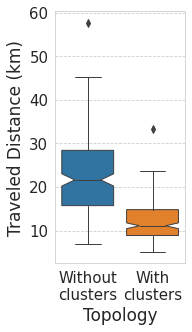

In [50]:
fig, axes = plt.subplots(figsize = (3, 5))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
g = sns.boxplot(x = df.topologia, y = df.weight, linewidth = 1.0, notch = True, showfliers = True, showmeans = False, order = ["Without\nclusters", "With\nclusters"], palette = sns.color_palette("tab10", 2), ax = axes)
g.tick_params(labelsize = 15)
g.set_xlabel("Topology", fontsize = 17)
g.set_ylabel("Traveled Distance (km)", fontsize = 17)
plt.subplots_adjust(left=0.3, right=0.9, bottom=0.2, top=0.9)
fig.savefig('/home/julio/Downloads/comparativo_custo.png', format='png', dpi=300)

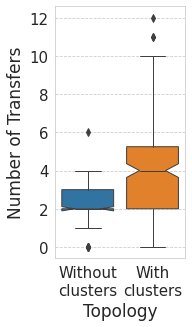

In [51]:
fig, axes = plt.subplots(figsize = (3, 5))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
g = sns.boxplot(x = df.topologia, y = df.baldeacoes, linewidth = 1.0, notch = True, showfliers = True, order = ["Without\nclusters", "With\nclusters"], palette = sns.color_palette("tab10", 2), ax = axes)
g.tick_params(labelsize = 15)
g.set_xlabel("Topology", fontsize = 17)
g.set_ylabel("Number of Transfers", fontsize = 17)
plt.subplots_adjust(left=0.3, right=0.9, bottom=0.2, top=0.9)
fig.savefig('/home/julio/Downloads/comparativo_custo_baldeacao.png', format='png', dpi=300)

In [242]:
df.query('viagem == 2002316')

,viagem,p0_lat,p0_long,p1_lat,p1_long,comb0,comb1,idx,topologia,weight,line_code,cluster,baldeacoes,d0,d1
0,2002316,-25.441532,-49.269946,-25.508195,-49.282243,110207-778,150194-030,0,Without clusters,18222.000000,3,0,2,77.880112,333.377694
187,2002316,-25.441532,-49.269946,-25.508195,-49.282243,110207,150194,1,With clusters,8557.972427,14,9,4,475.325857,104.775975


In [248]:
paths.query("viagem == 2002316 and topologia == 'With clusters' and idx == 1 and comb0 == '110207' and comb1 == '150194'").head(100)

,id,dummy_legacy_id,latitude,longitude,name_normalized,weight,line_code,itinerary_id,order,idx,viagem,p0_lat,p0_long,p1_lat,p1_long,comb0,comb1,topologia,cluster
180006,110207,110207,-25.442215,-49.269663,"Av. Iguaçu, 832 - Rebouças",NaN,NaN,NaN,0,1,2002316,-25.441532,-49.269946,-25.508195,-49.282243,110207,150194,With clusters,NaN
180007,110023,110023,-25.444238,-49.271078,"Rua Vinte e Quatro de Maio, 712 - Rebouças",266.042719,cluster-3,cluster-3,1,1,2002316,-25.441532,-49.269946,-25.508195,-49.282243,110207,150194,With clusters,cluster-3
180008,110184,110184,-25.446178,-49.270925,"Rua Eng. Rebouças, 2664 - Jardim Botânico",295.000000,863,12477,2,1,2002316,-25.441532,-49.269946,-25.508195,-49.282243,110207,150194,With clusters,NaN
180009,150721,150721,-25.449942,-49.270820,"Rua Lamenha Lins, 1592 - Rebouças",418.669866,cluster-17,cluster-17,3,1,2002316,-25.441532,-49.269946,-25.508195,-49.282243,110207,150194,With clusters,cluster-17
180010,150722,150722,-25.452151,-49.269753,"Rua Lamenha Lins, 1849 - Rebouças",268.000000,560,11096,4,1,2002316,-25.441532,-49.269946,-25.508195,-49.282243,110207,150194,With clusters,NaN
180011,150008,150008,-25.460568,-49.273367,"Av. Pres. Kennedy, 1472 - Água Verde",1003.807249,cluster-27,cluster-27,5,1,2002316,-25.441532,-49.269946,-25.508195,-49.282243,110207,150194,With clusters,cluster-27
180012,150010,150010,-25.462720,-49.275764,"Av. Pres. Kennedy, 1840 - Água Verde",339.000000,663,895,6,1,2002316,-25.441532,-49.269946,-25.508195,-49.282243,110207,150194,With clusters,NaN
180013,150012,150012,-25.464510,-49.277767,"Av. Pres. Kennedy, 2192 - Portão",282.881315,cluster-28,cluster-28,7,1,2002316,-25.441532,-49.269946,-25.508195,-49.282243,110207,150194,With clusters,cluster-28
180014,150014,150014,-25.466312,-49.279763,"Av. Pres. Kennedy, 2416 - Água Verde",294.000000,663,895,8,1,2002316,-25.441532,-49.269946,-25.508195,-49.282243,110207,150194,With clusters,NaN
180015,150022,150022,-25.473617,-49.287850,"Av. Pres. Kennedy, 3568 - Portão",1148.493100,cluster-53,cluster-53,9,1,2002316,-25.441532,-49.269946,-25.508195,-49.282243,110207,150194,With clusters,cluster-53


In [42]:
viagem = 2262497

mapa = folium.Map(
    location = [-25.4284, -49.2733],
    tiles = "OpenStreetMap",
    zoom_start = 12
)

attr = {'fill': 'black', 'font-weight': 'bold', 'font-size': '12'}
colors = [    
    'blue',
    'gray',
    'darkred',
    'orange',
    'green',
    'darkblue',
    'lightblue',
    'purple',
    'pink',
    'cadetblue',
    'lightgray',
    'blue',
    'gray',
    'darkred',
    'orange',
    'green',
    'darkblue',
    'lightblue',
    'purple',
    'pink',
    'cadetblue',
    'lightgray'    
]

b = a.filter(['id', 'name_normalized','latitude', 'longitude']).drop_duplicates()

for topologia in list(paths.topologia.drop_duplicates()):

    for index_comb, comb in paths.query(f"viagem == {viagem} and topologia == '{topologia}'").groupby(['p0_lat', 'p0_long', 'p1_lat', 'p1_long', 'comb0', 'comb1', 'idx']).agg({'weight': 'sum', 'line_code': 'nunique'}).reset_index().sort_values(by = ['line_code', 'weight'], ascending = True).head(1).iterrows():

        i = 0
        c = 0
        pontos = []
        p0 = None
        lc = None

        path = paths.query(f"comb0 == '{comb['comb0']}' and comb1 == '{comb['comb1']}' and idx == {comb['idx']} and topologia == '{topologia}'").copy()

        lines = path.line_code.nunique()
        clusters = path.cluster.nunique()
        length = path.weight.sum()

        feature_group = folium.FeatureGroup(name = f"topologia: {topologia} baldeacoes: {lines - clusters - 1} length: {length}")

        p0 = (comb['p0_lat'], comb['p0_long']) 

        folium.Marker(p0, popup = "Origem", 
                icon = folium.Icon(
                color = "red",
                prefix = "fa",
                icon = "house"
            )).add_to(feature_group)    

        for index, bus_stop in path.iterrows():

            p = [bus_stop["latitude"], bus_stop["longitude"]]       
            if lc is not None:
                if lc != bus_stop['line_code']:
                    if i > 1:
                        c = c + 1

            vcolor = colors[c]        
            if i > 0:
                lcolor = colors[c]
            else:
                lcolor = "red"        
            folium.Marker(p, popup = bus_stop["name_normalized"], 
                    icon = folium.Icon(
                    color = vcolor,
                    prefix = "fa",
                    icon = "bus"
                )).add_to(feature_group)        
            line = folium.PolyLine([p, p0], color = lcolor).add_to(feature_group)
            plugins.PolyLineTextPath(
                line,
                bus_stop['line_code'],
                center = True,
                offset = 12,
                attributes = attr).add_to(feature_group)
            p0 = p
            lc = bus_stop['line_code']
            i = i + 1

        p = (comb['p1_lat'], comb['p1_long'])
        folium.Marker(p, popup = "Destino", 
                icon = folium.Icon(
                color = "black",
                prefix = "fa",
                icon = "flag-checkered"
            )).add_to(feature_group)      
        line = folium.PolyLine([p, p0], color = "black").add_to(feature_group)

        mapa.add_child(feature_group)
    
mapa.add_child(folium.LayerControl()) 
    
plugins.Fullscreen(                                                         
        position                = "topright",                                   
        title                   = "Open full-screen map",                       
        title_cancel            = "Close full-screen map",                      
        force_separate_button   = True,                                         
    ).add_to(mapa) 

mapa.save(outfile = "map.html")
web.open_new_tab("map.html")

True

In [41]:
melhores.query("topologia == 'With clusters'").sort_values('line_code').head(30)

,viagem,p0_lat,p0_long,p1_lat,p1_long,comb0,comb1,idx,topologia,weight,line_code,cluster,baldeacoes
0,2163936,-25.460698,-49.209698,-25.428520,-49.262815,108145-302,109036,0,With clusters,9734.000000,2,0,1
186,1137632,-25.430218,-49.266688,-25.444620,-49.219362,110003,108151-302,0,With clusters,7774.787893,3,1,1
93,1922995,-25.376871,-49.323518,-25.425391,-49.320560,190454,190949,0,With clusters,7219.499450,3,1,1
93,1049304,-25.426974,-49.261087,-25.475594,-49.200109,110072,140098-331,0,With clusters,13472.678445,3,1,1
62,1513332,-25.493038,-49.293987,-25.529766,-49.336522,170170,171007,0,With clusters,11373.879540,3,2,0
33,547282,-25.432517,-49.275583,-25.428960,-49.329488,103303,190003-870,2,With clusters,6196.194889,3,2,0
155,1806762,-25.369660,-49.213188,-25.414221,-49.236389,120467,130276,0,With clusters,14839.000000,3,0,2
31,540322,-25.427016,-49.350035,-25.427262,-49.287110,190073-040,190824,0,With clusters,9935.194011,4,2,1
124,1012002,-25.563528,-49.341859,-25.499335,-49.328058,170649-773,180084-040,0,With clusters,8372.428353,4,2,1
31,2236346,-25.422733,-49.262063,-25.482118,-49.203523,110041,140090,0,With clusters,13161.527996,4,2,1


In [33]:
melhores.query("viagem == 1182112")

,viagem,p0_lat,p0_long,p1_lat,p1_long,comb0,comb1,idx,topologia,weight,line_code,cluster,baldeacoes
310,1182112,-25.468814,-49.194929,-25.435752,-49.308515,140411,1377087,0,Without clusters,24339.00000,2,2,-1
248,1182112,-25.468814,-49.194929,-25.435752,-49.308515,140411,190234,0,With clusters,14589.68562,9,4,4


In [82]:
viagens_invalidas = []
b = a.filter(['id', 'name_normalized','latitude', 'longitude']).drop_duplicates()
for idx_viagem, viagem in melhores.query("topologia == 'Without clusters'").iterrows():
    comb0 = list(b.query(f"id == '{viagem['comb0']}'").filter(['latitude', 'longitude']).to_records(index = False))[0]
    p0 = (viagem['p0_lat'], viagem["p0_long"])
    comb1 = list(b.query(f"id == '{viagem['comb1']}'").filter(['latitude', 'longitude']).to_records(index = False))[0]
    p1 = (viagem['p1_lat'], viagem["p1_long"])
    d0 = haversine(p0, comb0, unit = Unit.METERS)
    d1 = haversine(p1, comb1, unit = Unit.METERS)
    if d0 > 600 or d1 > 600:
        viagens_invalidas.append(viagem['viagem'])

In [21]:
b = a.filter(['id', 'dummy_legacy_id', 'latitude', 'longitude', 'name_normalized']).drop_duplicates()

In [125]:
procurar_bus_stops(b, p0, 200, 3)

['170183', '170186', '170184']

In [120]:
l

[(170183, 56.25096755169413),
 (170185, 106.5103231394336),
 (170186, 102.11267797243279),
 (170184, 50.71266621915328)]

In [121]:
list(pd.DataFrame(l, columns = ['dummy_legacy_id', 'd']).sort_values(by = 'd', ascending = True).dummy_legacy_id.head(L))

[170184, 170183, 170186]

In [47]:
combinacoes

[('130308', '102007'),
 ('130308', '108171'),
 ('130308', '108030'),
 ('130308', '108169'),
 ('130308', '102025'),
 ('130308', '102027'),
 ('130308', '102014'),
 ('130308', '102017'),
 ('130308', '102006'),
 ('130308', '108216'),
 ('130308', '102004'),
 ('130308', '102003'),
 ('130308', '102002'),
 ('130308', '102005'),
 ('130308', '102001'),
 ('130308', '102033'),
 ('130308', '102028'),
 ('130308', '102029'),
 ('130308', '102030'),
 ('130308', '102011'),
 ('130308', '102009'),
 ('130308', '102010'),
 ('130308', '102031'),
 ('130308', '102032'),
 ('130308', '102036'),
 ('130308', '102026-863'),
 ('130308', '102026-979'),
 ('130307', '102007'),
 ('130307', '108171'),
 ('130307', '108030'),
 ('130307', '108169'),
 ('130307', '102025'),
 ('130307', '102027'),
 ('130307', '102014'),
 ('130307', '102017'),
 ('130307', '102006'),
 ('130307', '108216'),
 ('130307', '102004'),
 ('130307', '102003'),
 ('130307', '102002'),
 ('130307', '102005'),
 ('130307', '102001'),
 ('130307', '102033'),
 ('